<a href="https://colab.research.google.com/github/ErenCim/CCC-Solutions/blob/main/Audio_Stream/Clustering_for_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opensmile xgboost librosa soundfile pandas scikit-learn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.9/324.9 kB 27.3 MB/s eta 0:00:00


In [3]:
from pydub import AudioSegment
import os
import opensmile
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans

In [4]:
data_folder = "/content/drive/MyDrive/Segmented Interview Information"

### Collecting all of the segment data with features into one data structure

In [5]:
feature_cols = [
    "F0semitoneFrom27.5Hz_sma3nz_amean",
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "loudness_sma3_amean",
    "HNRdBACF_sma3nz_amean",
    "jitterLocal_sma3nz_amean",
    "shimmerLocaldB_sma3nz_amean",
    "alphaRatioV_sma3nz_amean",
    "logRelF0-H1-H2_sma3nz_amean",
    "mfcc1_sma3_amean",
    "mfcc2_sma3_amean",
    "mfcc3_sma3_amean",
    "mfcc4_sma3_amean",
    "spectralFlux_sma3_amean",
    "slopeV0-500_sma3nz_amean"
]

# Collect data from all CSVs
all_dfs = []

for filename in os.listdir(data_folder):
    if filename.endswith("_all_features.csv"):
        file_path = os.path.join(data_folder, filename)
        try:
            df = pd.read_csv(file_path)
            if all(col in df.columns for col in feature_cols):
                all_dfs.append(df[["file_id", "timestamp"] + feature_cols])
            else:
                print(f"Skipping {filename} — missing required features.")
        except Exception as e:
            print(f"Failed to load {filename}: {e}")

# Combine all DataFrames
if not all_dfs:
    raise ValueError("No valid feature CSVs found in the folder.")

combined_df = pd.concat(all_dfs, ignore_index=True)

### Training clustering algorithm with all of the data
Provides the mean of each feature for each cluster

In [6]:
combined_df = pd.concat(all_dfs, ignore_index=True)

# Prepare data matrix
X = combined_df[feature_cols].fillna(0)

# Scale and cluster
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add labels back to the data
combined_df["cluster"] = cluster_labels

# Show cluster center summary
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary = pd.DataFrame(cluster_centers, columns=feature_cols)
cluster_summary.index.name = "cluster"

print("✅ Cluster Summary:")
print(cluster_summary)

# Save full result
output_path = os.path.join(data_folder, "combined_clusters.csv")
combined_df.to_csv(output_path, index=False)
print(f"\n📄 Cluster-labeled data saved to: {output_path}")

✅ Cluster Summary:
         F0semitoneFrom27.5Hz_sma3nz_amean  \
cluster                                      
0                                20.675489   
1                                26.457733   
2                                19.221351   
3                                24.883968   
4                                32.081289   
5                                24.921655   

         F0semitoneFrom27.5Hz_sma3nz_stddevNorm  loudness_sma3_amean  \
cluster                                                                
0                                      0.263434             0.361519   
1                                      0.335034             0.343874   
2                                      0.326800             0.245645   
3                                      0.230010             0.421609   
4                                      0.224280             0.492071   
5                                      0.250576             0.608940   

         HNRdBACF_sma3nz_amean  jit

### 3D Visualization of the clustering

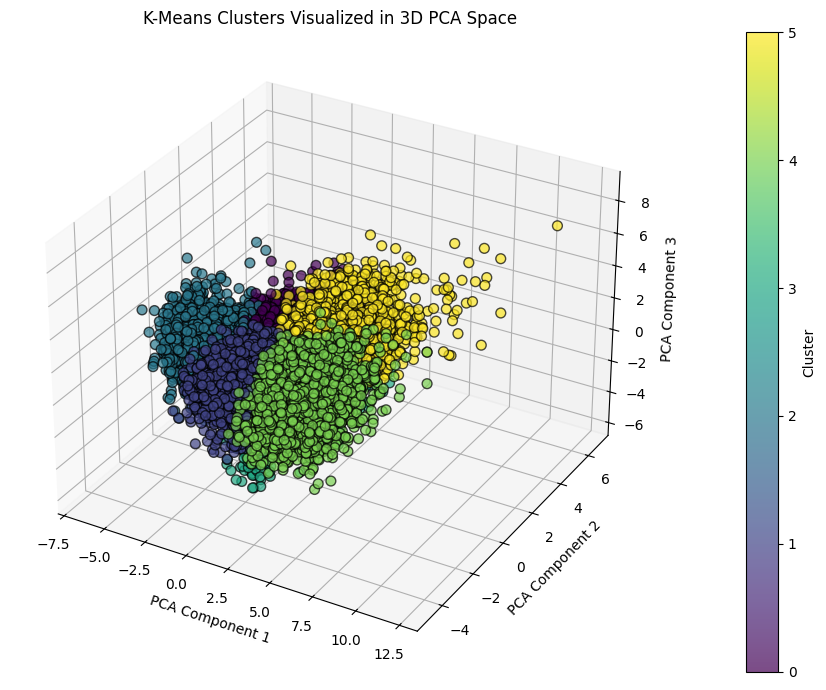

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This is needed for 3D plotting

# Reduce to 3 components for 3D plotting
X_pca_3d = PCA(n_components=3).fit_transform(X_scaled)

# 3D Scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=cluster_labels,
    cmap='viridis',
    s=50,
    alpha=0.7,
    edgecolor='k'
)

ax.set_title("K-Means Clusters Visualized in 3D PCA Space")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# Add color legend
legend = fig.colorbar(scatter, ax=ax, pad=0.1)
legend.set_label("Cluster")

plt.tight_layout()
plt.show()

### Printing the mean of each

In [18]:
combined_df.groupby("cluster")[feature_cols].mean()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,loudness_sma3_amean,HNRdBACF_sma3nz_amean,jitterLocal_sma3nz_amean,shimmerLocaldB_sma3nz_amean,alphaRatioV_sma3nz_amean,logRelF0-H1-H2_sma3nz_amean,mfcc1_sma3_amean,mfcc2_sma3_amean,mfcc3_sma3_amean,mfcc4_sma3_amean,spectralFlux_sma3_amean,slopeV0-500_sma3nz_amean
cluster,,,,,,,,,,,,,,
0,20.676347,0.263493,0.361392,-1.272440,0.072528,1.435181,-13.061582,-0.478412,20.648091,7.696883,8.786346,1.489779,0.156659,0.035147
1,26.457953,0.334978,0.343843,1.370111,0.055192,1.221065,-12.442015,2.527066,19.572922,7.075333,6.434213,1.507292,0.126815,0.030697
2,19.222515,0.326850,0.245643,-2.522508,0.081243,1.291579,-12.336352,0.672608,17.451983,8.679541,8.535969,7.008007,0.085232,0.007053
3,24.877098,0.229933,0.421790,1.593223,0.053019,1.332256,-14.967113,2.634431,22.766148,9.531776,7.096587,-0.781686,0.194877,0.049375
4,32.081815,0.224261,0.492061,4.299991,0.038433,1.172455,-12.066643,4.822573,21.217388,3.645672,6.285289,-5.359942,0.203756,0.050686
5,24.925225,0.250618,0.608954,0.648087,0.057988,1.418018,-11.700872,1.735059,21.901244,2.513892,10.030112,-3.470247,0.316098,0.055916


### Clustering label generated by an LLM based on the mean values of the extracted features

In [15]:
cluster_labels = {
    0: "Tense (low confidence)",
    1: "Neutral",
    2: "Nervous",
    3: "Energetic and Assertive",
    4: "Enthusiastic",
    5: "Expressive and Engaged"
}

### Saving the trained model to google drive for future use

In [10]:
import joblib

# Save the trained scaler
joblib.dump(scaler, "/content/drive/MyDrive/Segmented Interview Information/Saved Model/emotion_scaler.pkl")

# Save the trained KMeans model
joblib.dump(kmeans, "/content/drive/MyDrive/Segmented Interview Information/Saved Model/emotion_kmeans_model.pkl")

# Optional: save cluster center summary
cluster_summary.to_csv("/content/drive/MyDrive/Segmented Interview Information/Saved Model/emotion_kmeans_cluster_summary.csv")

### Testing the model with a foreign interview

In [11]:
audio = AudioSegment.from_wav("/content/sample_data/OSR_us_000_0030_8k.wav")  # Replace with your file path
segment_duration_ms = 3000
step_size = 1500  # 50% overlap

In [12]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals
)

### Preprocessing the new interview

In [13]:
segments = []
file_id = "new_audio"

# Updated feature columns for emotion clustering
feature_cols = [
    "F0semitoneFrom27.5Hz_sma3nz_amean",
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "loudness_sma3_amean",
    "HNRdBACF_sma3nz_amean",
    "jitterLocal_sma3nz_amean",
    "shimmerLocaldB_sma3nz_amean",
    "alphaRatioV_sma3nz_amean",
    "logRelF0-H1-H2_sma3nz_amean",
    "mfcc1_sma3_amean",
    "mfcc2_sma3_amean",
    "mfcc3_sma3_amean",
    "mfcc4_sma3_amean",
    "spectralFlux_sma3_amean",
    "slopeV0-500_sma3nz_amean"
]

# Segment audio
for i in range(0, len(audio) - segment_duration_ms + 1, step_size):
    segment = audio[i:i + segment_duration_ms]
    segment_path = f"/tmp/{file_id}_segment_{i}.wav"
    segment.export(segment_path, format="wav")

    # Extract features
    features_df = smile.process_file(segment_path).reset_index(drop=True).round(3)
    features = features_df.to_dict("records")[0]
    os.remove(segment_path)

    # Timestamp
    start_sec = i // 1000
    end_sec = (i + segment_duration_ms) // 1000
    timestamp = f"{start_sec//60:02d}:{start_sec%60:02d} - {end_sec//60:02d}:{end_sec%60:02d}"

    # Build feature row with all required features
    feature_row = {"file_id": file_id, "timestamp": timestamp}
    for col in feature_cols:
        feature_row[col] = features.get(col)

    segments.append(feature_row)

### Generate labels for the segments of the new interview

In [16]:
# Create DataFrame from extracted segments
df_test = pd.DataFrame(segments)

# Feature columns used for training the emotion model
feature_cols = [
    "F0semitoneFrom27.5Hz_sma3nz_amean",
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "loudness_sma3_amean",
    "HNRdBACF_sma3nz_amean",
    "jitterLocal_sma3nz_amean",
    "shimmerLocaldB_sma3nz_amean",
    "alphaRatioV_sma3nz_amean",
    "logRelF0-H1-H2_sma3nz_amean",
    "mfcc1_sma3_amean",
    "mfcc2_sma3_amean",
    "mfcc3_sma3_amean",
    "mfcc4_sma3_amean",
    "spectralFlux_sma3_amean",
    "slopeV0-500_sma3nz_amean"
]

# Prepare data and make predictions
X_test = df_test[feature_cols].fillna(0)
X_test_scaled = scaler.transform(X_test)
cluster_preds = kmeans.predict(X_test_scaled)

# Assign predicted cluster and corresponding emotion label
df_test["cluster"] = cluster_preds
df_test["cluster_label"] = df_test["cluster"].map(cluster_labels)

# Display all results
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 0)

print(df_test[["timestamp", "cluster", "cluster_label"]])

        timestamp  cluster            cluster_label
0   00:00 - 00:03        1                  Neutral
1   00:01 - 00:04        3  Energetic and Assertive
2   00:03 - 00:06        3  Energetic and Assertive
3   00:04 - 00:07        1                  Neutral
4   00:06 - 00:09        1                  Neutral
5   00:07 - 00:10        4             Enthusiastic
6   00:09 - 00:12        3  Energetic and Assertive
7   00:10 - 00:13        3  Energetic and Assertive
8   00:12 - 00:15        3  Energetic and Assertive
9   00:13 - 00:16        3  Energetic and Assertive
10  00:15 - 00:18        3  Energetic and Assertive
11  00:16 - 00:19        1                  Neutral
12  00:18 - 00:21        1                  Neutral
13  00:19 - 00:22        3  Energetic and Assertive
14  00:21 - 00:24        3  Energetic and Assertive
15  00:22 - 00:25        3  Energetic and Assertive
16  00:24 - 00:27        1                  Neutral
17  00:25 - 00:28        1                  Neutral
18  00:27 - 

### Load the model from google drive and test a new interview with it
Need to run the segmenting for the new interview above for this code block to work.

This is to ensure that the saved models can be imported and used properly with new interviews.

In [31]:
# Load data and models
df_new = pd.DataFrame(segments)

scaler_new = joblib.load("/content/drive/MyDrive/Segmented Interview Information/Saved Model/emotion_scaler.pkl")
kmeans_new = joblib.load("/content/drive/MyDrive/Segmented Interview Information/Saved Model/emotion_kmeans_model.pkl")

feature_cols = [
    "F0semitoneFrom27.5Hz_sma3nz_amean",
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "loudness_sma3_amean",
    "HNRdBACF_sma3nz_amean",
    "jitterLocal_sma3nz_amean",
    "shimmerLocaldB_sma3nz_amean",
    "alphaRatioV_sma3nz_amean",
    "logRelF0-H1-H2_sma3nz_amean",
    "mfcc1_sma3_amean",
    "mfcc2_sma3_amean",
    "mfcc3_sma3_amean",
    "mfcc4_sma3_amean",
    "spectralFlux_sma3_amean",
    "slopeV0-500_sma3nz_amean"
]

# Re-scale and re-predict cluster labels
X_new = df_test[feature_cols].fillna(0)
X_new_scaled = scaler.transform(X_new)
predicted_clusters = kmeans.predict(X_test_scaled)

# Map clusters to confidence labels
cluster_labels = {
    0: "Tense (low confidence)",
    1: "Neutral",
    2: "Nervous",
    3: "Energetic and Assertive",
    4: "Enthusiastic",
    5: "Expressive and Engaged"
}

# Add predictions to DataFrame
df_new["reclustered"] = predicted_clusters
df_new["reconf_label"] = df_new["reclustered"].map(cluster_labels)

# Show the result
print(df_new[["timestamp", "reclustered", "reconf_label"]])


        timestamp  reclustered             reconf_label
0   00:00 - 00:03            1                  Neutral
1   00:01 - 00:04            3  Energetic and Assertive
2   00:03 - 00:06            3  Energetic and Assertive
3   00:04 - 00:07            1                  Neutral
4   00:06 - 00:09            1                  Neutral
5   00:07 - 00:10            4             Enthusiastic
6   00:09 - 00:12            3  Energetic and Assertive
7   00:10 - 00:13            3  Energetic and Assertive
8   00:12 - 00:15            3  Energetic and Assertive
9   00:13 - 00:16            3  Energetic and Assertive
10  00:15 - 00:18            3  Energetic and Assertive
11  00:16 - 00:19            1                  Neutral
12  00:18 - 00:21            1                  Neutral
13  00:19 - 00:22            3  Energetic and Assertive
14  00:21 - 00:24            3  Energetic and Assertive
15  00:22 - 00:25            3  Energetic and Assertive
16  00:24 - 00:27            1                  

### Load excitement scores of MIT graders
Find the average excitement score for each interview given by the graders in MIT to see which interviews have an overall high excitement score to comapre results with.

In [23]:
csv_path = "/content/sample_data/turker_scores_full_interview.csv"

df = pd.read_csv(csv_path)

avg_excited = df.groupby("Participant")["Excited"].mean()

print("Average 'Excited' rating per participant:")
print(avg_excited)

Average 'Excited' rating per participant:
Participant
p1      5.204389
p10     4.338395
p11     4.129776
p12     5.232253
p13     3.257951
p14     5.320462
p15     4.753809
p16     6.004993
p17     4.532394
p20     3.900192
p21     4.857801
p22     3.993795
p24     6.001494
p25     5.204112
p27     4.334080
p29     4.450085
p3      5.760159
p30     2.701719
p31     5.332994
p32     5.906935
p33     5.230290
p34     5.884917
p35     5.116483
p37     5.234646
p4      4.226134
p42     4.879071
p43     5.005420
p44     3.679198
p45     5.745163
p47     3.017146
p48     3.779090
p49     5.443358
p5      4.770706
p50     3.899417
p52     3.348415
p53     4.783837
p55     4.431819
p56     3.665165
p57     6.214033
p58     3.552710
p59     5.015663
p6      4.564826
p60     5.441999
p61     2.804542
p62     4.666673
p63     3.790942
p64     4.338882
p65     4.253060
p66     6.221416
p67     5.673684
p69     3.012548
p7      4.988605
p70     5.026687
p71     4.451358
p72     3.903537
p73     5.0

### Compare the segment by segment emotion prediction by the model with average graded excitement score
The average excitement score of PP61, graded manually, was around 2. While for PP66 was around 6. So, the code below was used to assigna an emotion to each segment of both of these interviews and the different was observed/used as a proof of concept that the model makes accurate predictions.

We can see that the predictionsof PP66 are mostly excited while for PP61, it is mostly neutral and nervous.

In [32]:
# Load data and models
df_new = pd.read_csv("/content/drive/MyDrive/Segmented Interview Information/PP61_all_features.csv")

scaler_new = joblib.load("/content/drive/MyDrive/Segmented Interview Information/Saved Model/emotion_scaler.pkl")
kmeans_new = joblib.load("/content/drive/MyDrive/Segmented Interview Information/Saved Model/emotion_kmeans_model.pkl")

# Define the feature columns used in training
feature_cols = [
    "F0semitoneFrom27.5Hz_sma3nz_amean",
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "loudness_sma3_amean",
    "HNRdBACF_sma3nz_amean",
    "jitterLocal_sma3nz_amean",
    "shimmerLocaldB_sma3nz_amean",
    "alphaRatioV_sma3nz_amean",
    "logRelF0-H1-H2_sma3nz_amean",
    "mfcc1_sma3_amean",
    "mfcc2_sma3_amean",
    "mfcc3_sma3_amean",
    "mfcc4_sma3_amean",
    "spectralFlux_sma3_amean",
    "slopeV0-500_sma3nz_amean"
]

# Map cluster labels
cluster_labels = {
    0: "Tense (low confidence)",
    1: "Neutral",
    2: "Nervous",
    3: "Energetic and Assertive",
    4: "Enthusiastic",
    5: "Expressive and Engaged"
}

# Drop rows with missing feature values
df_valid = df_new.dropna(subset=feature_cols)

# Scale features and predict clusters
X_new_scaled = scaler_new.transform(df_valid[feature_cols])
predicted_clusters = kmeans_new.predict(X_new_scaled)

# Assign predictions
df_valid["reclustered"] = predicted_clusters
df_valid["reconf_label"] = df_valid["reclustered"].map(cluster_labels)

# Show the result
print(df_valid[["timestamp", "reclustered", "reconf_label"]])


        timestamp  reclustered            reconf_label
0   00:00 - 00:05            1                 Neutral
1   00:02 - 00:07            1                 Neutral
2   00:05 - 00:10            1                 Neutral
3   00:07 - 00:12            2                 Nervous
4   00:10 - 00:15            2                 Nervous
5   00:12 - 00:17            2                 Nervous
6   00:15 - 00:20            2                 Nervous
7   00:17 - 00:22            2                 Nervous
8   00:20 - 00:25            1                 Neutral
9   00:22 - 00:27            1                 Neutral
10  00:25 - 00:30            1                 Neutral
11  00:27 - 00:32            2                 Nervous
12  00:30 - 00:35            2                 Nervous
13  00:32 - 00:37            2                 Nervous
14  00:35 - 00:40            2                 Nervous
15  00:37 - 00:42            2                 Nervous
16  00:40 - 00:45            2                 Nervous
17  00:42 